In [47]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import swiapi
import flopy

# path to mf6 shared library
# executables based on mf6 feat-swi branch at: 
#   https://github.com/langevin-usgs/modflow6/tree/feat-swi
mf6exe = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
libmf6 = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/libmf6.dylib"


## Setup Functions

In [48]:
def get_simulation(ws, idx):

    # idx 0: confined
    # idx 1: unconfined
    # idx 2: newton unconfined
    if idx == 0:
        top = 0.
        newtonoptions = False
        icelltype = 0
    elif idx == 1:
        top = 50.
        newtonoptions = False
        icelltype = 1
    elif idx == 2:
        top = 50.
        newtonoptions = "newton"
        icelltype = 1

    #create simple test model
    Lx = 10000 # meters
    delr, delc = 100., 1.
    ncol = int(Lx / delr) + 1
    nlay = 1
    nrow = 1
    botm = -400.
    recharge = 0.001
    k = 10.
    h0 = 0.
    h1 = h0
    icelltype = 1

    name = 'mymodel'
    sim = flopy.mf6.MFSimulation(
        sim_name=name, 
        sim_ws=ws, 
        exe_name=mf6exe,
        memory_print_option="all"
    )
    nper = 1
    nstp = 1
    perlen = 1.
    perioddata = nper * [(perlen, nstp, 1.)]
    tdis = flopy.mf6.ModflowTdis(sim, perioddata=perioddata)
    ims = flopy.mf6.ModflowIms(
        sim, 
        print_option="summary",
        linear_acceleration="BICGSTAB",
        outer_maximum=200,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, 
        modelname=name, 
        save_flows=True, 
        newtonoptions=newtonoptions,
    )
    dis = flopy.mf6.ModflowGwfdis(
        gwf, 
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    ic = flopy.mf6.ModflowGwfic(gwf, strt=0.)
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        alternative_cell_averaging="amt-hmk", #"harmonic",
        icelltype=icelltype,
        k=k,
    )
    zeta_file = name + '.zta'
    swi = flopy.mf6.ModflowGwfswi(gwf, zeta_filerecord=zeta_file, zetastrt=-1.)
    cghb = 10. * delr * delc / 10.
    ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=[[0, 0, 0, h0, cghb],
                                                        [0, 0, ncol - 1, h1, cghb]])
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    budget_file = name + '.bud'
    head_file = name + '.hds'
    oc = flopy.mf6.ModflowGwfoc(
            gwf,
            budget_filerecord=budget_file,
            head_filerecord=head_file,
            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    )
    return sim

def make_cross_section_plot(sim, idx, title):
    gwf = sim.gwf[0]
    x = gwf.modelgrid.xcellcenters.flatten()
    botm = gwf.dis.botm.array.flatten()
    ws = sim.sim_path
    fpth = pl.Path(ws) / "mymodel.zta"
    head = gwf.output.head().get_data().flatten()
    zeta = flopy.utils.HeadFile(fpth, text="zeta").get_data().flatten()

    if idx == 0:
        tp = np.zeros(head.shape)
    else:
        tp = head

    pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
    ax = pxs.ax
    ax.plot(x, head, "k-")
    ax.plot(x, zeta, "k--")
    ax.fill_between(x, tp, zeta, color="cyan")
    ax.fill_between(x, zeta, botm, color="red")
    ax.set_title(title)
    ax.set_ylim(-400, 50)

def analytical_head_unconfined(x, recharge, a, k, alphaf):
    return np.sqrt(recharge * (a ** 2 - x ** 2) / k / (1 + alphaf))

def analytical_head_confined(x, recharge, a, k, alphaf):
    return np.sqrt(recharge * (a ** 2 - x ** 2) / k / alphaf)

def make_head_plot(sim, idx, title):
    gwf = sim.gwf[0]
    ncol = gwf.dis.ncol.get_data()
    delr = gwf.dis.delr.get_data()[0]
    hk = gwf.npf.k.get_data()[0][0, 0]
    recharge = gwf.get_package("RCH").recharge.get_data()[0][0, 0] # period 0 and cell 0, 0
    jstart = int((ncol - 1) / 2)
    ax = plt.subplot(1, 1, 1)
    xc = gwf.modelgrid.xcellcenters.flatten()
    Lx = xc[-1] - xc[0]
    xoffset = Lx / 2 + delr / 2
    xanalytical = xc[jstart:] - xoffset
    if idx == 0:
        hanalytical = analytical_head_confined(xanalytical, recharge, Lx / 2., hk, 40)
    else:
        hanalytical = analytical_head_unconfined(xanalytical, recharge, Lx / 2., hk, 40)
    hmodel = sim.gwf[0].output.head().get_data().flatten()[jstart:]
    ax.plot(xanalytical, hanalytical, 'b-', label="analytical")
    ax.plot(xanalytical, hmodel, 'bo', mfc="none", label="numerical")
    ax.legend()
    ax.set_title(title)

## Case 1a -- Confined

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan 19 2024 11:29:29 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 


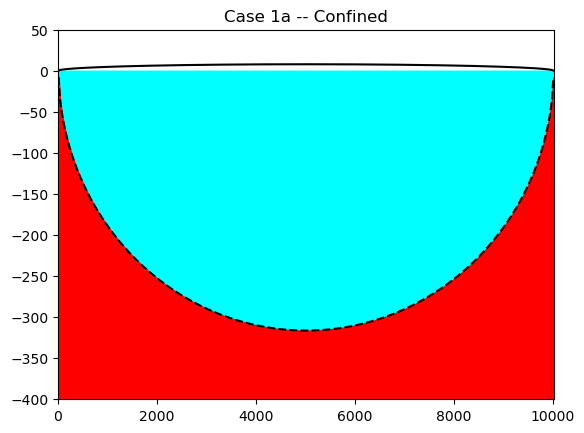

In [49]:
idx = 0
title = "Case 1a -- Confined"
sim = get_simulation("./mymodel", idx)
sim.write_simulation()
sim.run_simulation()
make_cross_section_plot(sim, idx, title)

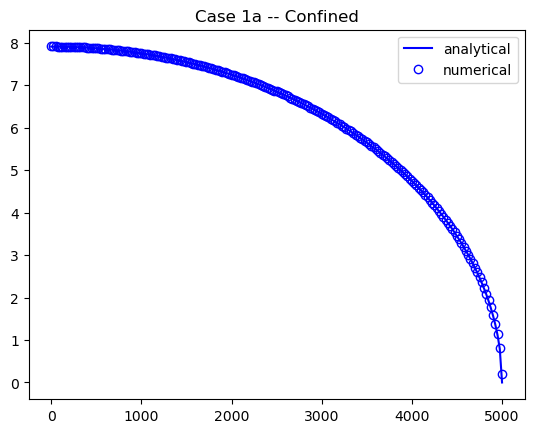

In [50]:
make_head_plot(sim, idx, title)

## Case 1b -- Unconfined

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan 19 2024 11:29:29 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 


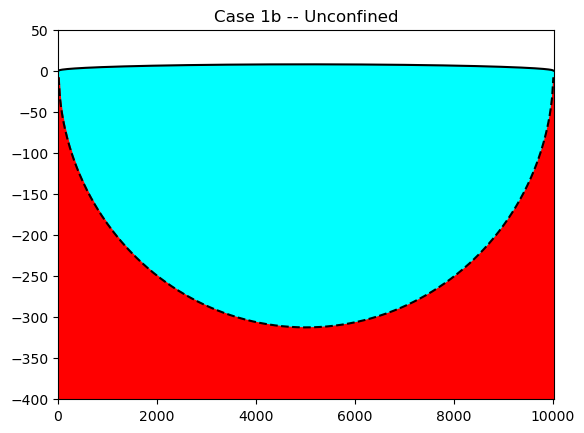

In [51]:
idx = 1
title = "Case 1b -- Unconfined"
sim = get_simulation("./mymodel", idx)
sim.write_simulation()
sim.run_simulation()
make_cross_section_plot(sim, idx, title)

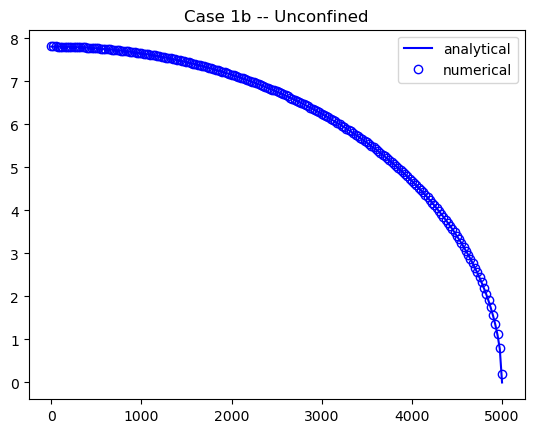

In [52]:
make_head_plot(sim, idx, title)

## Case 1c -- Unconfined Newton

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan 19 2024 11:29:29 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 


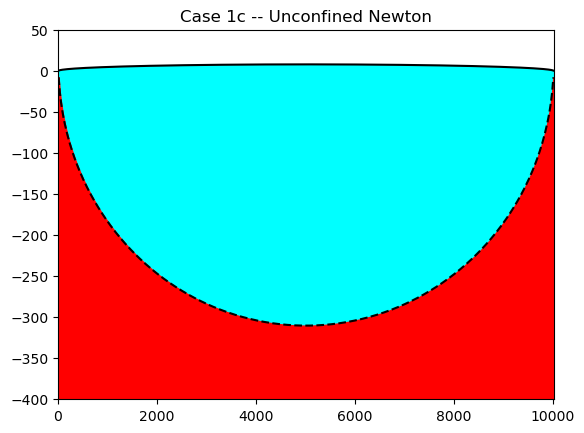

In [53]:
idx = 2
title = "Case 1c -- Unconfined Newton"
sim = get_simulation("./mymodel", idx)
sim.write_simulation()
sim.run_simulation()
make_cross_section_plot(sim, idx, title)

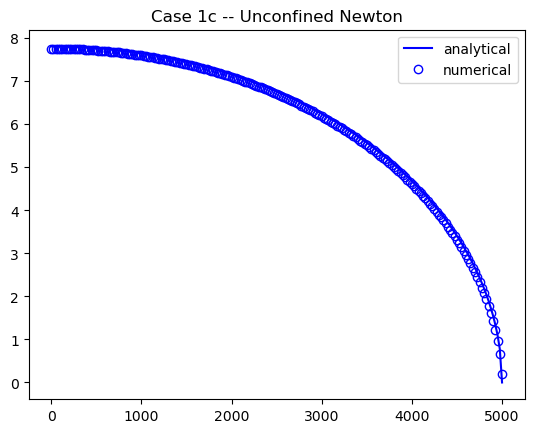

In [54]:
make_head_plot(sim, idx, title)